In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from barney_functionsCNNonly import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta, Adam
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import optuna
from optuna.integration import TFKerasPruningCallback
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

/Users/jhn949/opt/anaconda3/envs/TF/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Audio Load by Barney

In [47]:
mels = np.load('mels_train.npz')['data']
y = np.load('mels_train_labels.npz',allow_pickle=True)['data']
num_classes = len(np.unique(y))
mels, TEST_images, y, TEST_y = train_test_split(mels, y, test_size=0.2, random_state=42)

In [48]:
print(mels.shape)
print(y.shape)
print(TEST_images.shape)
print(TEST_y.shape)

(1424, 128, 51)
(1424,)
(356, 128, 51)
(356,)


# CNN

# Optimising

In [104]:
def objective(trial):
    
    n_epochs = 35
    learning_rate = 0.00041
    optimiser = Adam(learning_rate=learning_rate)
    
    filters_1 = 32
    kernel_1 = 12
    strides_1 = 1
    
    activation_1 = trial.suggest_categorical("activation_1", \
                            ["relu", "tanh", "selu", "elu"])
    
    padding_1 = 'same'
    input_shape = (img_rows, img_cols, 1)
    pool_size_1 = trial.suggest_int("pool_size_1",low=2,high=4,step=1)
    
    filters_2 = 62
    kernel_2 = 10
    strides_2 = 1
    padding_2 = 'same'
    activation_2 = trial.suggest_categorical("activation_2", \
                        ["relu", "tanh", "selu", "elu"])
    pool_size_2 = trial.suggest_int("pool_size_2",low=2,high=4,step=1)
    
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.9)
    
    lin_1_n = 102
    
    batch_size = 128
    
    model = Sequential()
    model.add(Conv2D(filters=filters_1,
                     kernel_size=kernel_1,
                     strides=strides_1,
                     padding=padding_1,
                     activation=activation_1,
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=pool_size_1, strides=None))
    model.add(Conv2D(filters=filters_2,
                     kernel_size=kernel_2,
                     strides=strides_2,
                     padding=padding_2,
                     activation=activation_2))
    model.add(MaxPooling2D(pool_size=pool_size_2, strides=None))
    model.add(Dropout(rate=dropout_rate))
    model.add(Flatten())
    model.add(Dense(units=lin_1_n, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    
    model.compile(loss=categorical_crossentropy,
              optimizer=optimiser,
              metrics=['categorical_accuracy'])
    
    monitor = "val_categorical_accuracy"
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5)]
        #TFKerasPruningCallback(trial, monitor)]
    
    fitted = model.fit(X_train, y_train,
                       batch_size=batch_size,
                       epochs=n_epochs,
                       verbose=1,
                       validation_data=(X_test, y_test),
                       callbacks=callbacks)
    
    score = fitted.history[monitor][-1]
    
    return score
# changed trials to 50 from 10
# removed pruning but not callbacks

In [105]:
train_images, val_images, train_labels, val_labels = train_test_split(mels, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test, img_rows, img_cols = format_for_CNN(train_images, val_images, train_labels, val_labels)
check_class_complete_gen(train_labels, val_labels,y)

OK


In [106]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2022-06-13 12:42:11,357] A new study created in memory with name: no-name-14ede495-3002-4c3d-a0b8-c65fcd1e62f2


Train on 1139 samples, validate on 285 samples
Epoch 1/35
 256/1139 [=====>........................] - ETA: 39s - loss: 1.5133 - categorical_accuracy: 0.2266

KeyboardInterrupt: 

In [22]:
optimised_params = study.best_params
print(optimised_params)

{'activation_1': 'tanh', 'pool_size_1': 2, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.34395485379984586}


In [28]:
np.save('optimised_params_Aleks',optimised_params)
'n_epochs': 35, 'learning_rate': 0.0006920615808798661, 'filters_1': 20, 'kernel_size_1': 8, 'filters_2': 48, 'kernel_size_2': 6, 'lin_1_n': 79

In [107]:
def opt_model(optimised_params):
    n_epochs = 35
    learning_rate = 0.0007
    optimiser = Adam(learning_rate=learning_rate)
    # Conv 1
    filters_1 = 20
    kernel_size_1 = 8
    strides_1 = 1
    padding_1 = 'same'
    activation_1 = 'tanh'
    input_shape = (img_rows, img_cols, 1)
    # Pool 1
    pool_size_1 = 2
    # Conv 2
    filters_2 = 48
    kernel_size_2 = 6
    strides_2 = 1
    padding_2 = 'same'
    activation_2 = 'tanh'
    # Pool 2
    pool_size_2 = 3
    # Droput
    dropout_rate = 0.344
    # Lin 1
    lin_1_n = 79
    
    model = Sequential()
    model.add(Conv2D(filters=filters_1,
                     kernel_size=kernel_size_1,
                     strides=strides_1,
                     padding=padding_1,
                     activation=activation_1,
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=pool_size_1, strides=None))
    model.add(Conv2D(filters=filters_2,
                     kernel_size=kernel_size_2,
                     strides=strides_2,
                     padding=padding_2,
                     activation=activation_2))
    model.add(MaxPooling2D(pool_size=pool_size_2, strides=None))
    model.add(Dropout(rate=dropout_rate))
    model.add(Flatten())
    model.add(Dense(units=lin_1_n, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    
    model.compile(loss=categorical_crossentropy,
              optimizer=optimiser,
              metrics=['categorical_accuracy'])
    
    return model

# Folding

In [108]:
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True)
X = mels
y = y 
# Human Optimisation...
check_class_complete(kfold,X,y)
#optimised_params['learning_rate'] = 0.0014280245429123698/2
#optimised_params['n_epochs'] = 30
n_epochs = 35
fold_loss = np.zeros((n_folds,n_epochs))
np.save('optimised_params',optimised_params)
print(optimised_params)

ALL CLASSES PRESENT
{'activation_1': 'tanh', 'pool_size_1': 2, 'activation_2': 'tanh', 'pool_size_2': 3, 'dropout_rate': 0.34395485379984586}


In [109]:
fold_no = 1
for train_index, test_index in kfold.split(X, y):
    
    print("-----------------------------------")
    print("FOLD "+str(fold_no))
    print("-----------------------------------")
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train,X_test,y_train,y_test, img_rows, img_cols = format_for_CNN(X_train,X_test,y_train,y_test)
    
    model = opt_model(optimised_params)

    history = model.fit(X_train, y_train,
                        batch_size=128,
                        epochs=n_epochs,
                        verbose=1,
                        validation_data=(X_test, y_test))
    
    fold_loss[fold_no-1] = history.history['val_categorical_accuracy']
    fold_no += 1

-----------------------------------
FOLD 1
-----------------------------------
Train on 1139 samples, validate on 285 samples
Epoch 1/35
1139/1139 [==============================] - 18s 16ms/sample - loss: 1.0918 - categorical_accuracy: 0.4899 - val_loss: 0.8613 - val_categorical_accuracy: 0.6140
Epoch 2/35
1139/1139 [==============================] - 18s 16ms/sample - loss: 0.7574 - categorical_accuracy: 0.6725 - val_loss: 0.7563 - val_categorical_accuracy: 0.6456
Epoch 3/35
1139/1139 [==============================] - 19s 16ms/sample - loss: 0.6416 - categorical_accuracy: 0.7357 - val_loss: 0.6219 - val_categorical_accuracy: 0.7053
Epoch 4/35
1139/1139 [==============================] - 19s 16ms/sample - loss: 0.5398 - categorical_accuracy: 0.7814 - val_loss: 0.6044 - val_categorical_accuracy: 0.7088
Epoch 5/35
1139/1139 [==============================] - 19s 16ms/sample - loss: 0.4964 - categorical_accuracy: 0.7849 - val_loss: 0.4700 - val_categorical_accuracy: 0.7965
Epoch 6/35
113

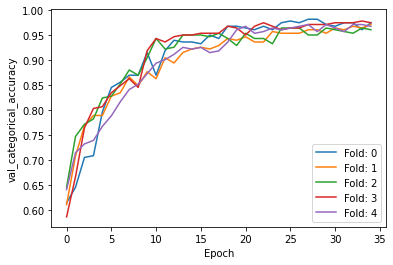

Mean val_categorical_accuracy:  0.9705


In [110]:
for i in range(n_folds):
    plt.plot(fold_loss[i], label='Fold: '+str(i))
plt.xlabel('Epoch')
plt.ylabel('val_categorical_accuracy')
plt.legend()
plt.show()
mean_acc = np.mean(fold_loss[:,-1])
print('Mean val_categorical_accuracy: ',np.around(mean_acc,5))

1st convolution layer:


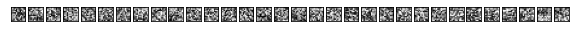

2nd convolution layer:


In [59]:
# model.layers will print a list of layer parameters/values
filters1, biases1 = model.layers[0].get_weights()
filters2, biases2 = model.layers[2].get_weights()

# normalize filter values to range 0-1 for better colormapping during plotting
def norm_filter(kernel):
    return (kernel - np.min(kernel)) / (np.max(kernel) - np.min(kernel))

n_1 = 32
print('1st convolution layer:')
fig, axs = plt.subplots(1,n_1, figsize=(10, 6))
axs = axs.ravel()
for i in range(n_1):
    axs[i].imshow(norm_filter(filters1[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)
plt.show()

n_2 = 62
print('2nd convolution layer:')
fig, axs = plt.subplots(1,n_2, figsize=(10, 6))
axs = axs.ravel()
for i in range(n_2):
    axs[i].imshow(norm_filter(filters2[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

### Evaluation

In [73]:
def format_for_CNN_TEST_INAUG(X_test,y_test):

    # Standardize pixel distribution to have zero mean and unit variance
    test_images = standardizeimg(img=X_test, mu=np.mean(X_test), sigma=np.std(X_test))

    # adapt to format required by tensorflow; Using channels_last --> (n_samples, img_rows, img_cols, n_channels)
    img_rows, img_cols = X_test.shape[1], X_test.shape[2] # input image dimensions
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

    # convert class vectors to binary class matrices - one hot encoding
    onehot_v = pd.get_dummies(y_test)
    y_test = onehot_v.to_numpy()
    
    return X_test,y_test,img_rows,img_cols

In [74]:
TEST = np.load('test-inaug.npz')['data']
TEST_y = np.load('test-inaug_labels.npz',allow_pickle=True)['data']
print(TEST.shape)
print(TEST_y.shape)
TEST_CNN,TEST_CNN_y, _, _ = format_for_CNN_TEST_INAUG(TEST, TEST_y)
print(TEST_CNN.shape)
print(TEST_CNN_y.shape)

(100, 128, 51)
(100,)
(100, 128, 51, 1)
(100, 4)


In [98]:
predicted_prob = model.predict(TEST_CNN)
predictions = np.argmax(predicted_prob, axis=1)

In [76]:
print(predictions.shape)
print(TEST_CNN_y.shape)

(100,)
(100, 4)


In [95]:
import itertools
from barney_functionsCNNonlyCopy1 import *

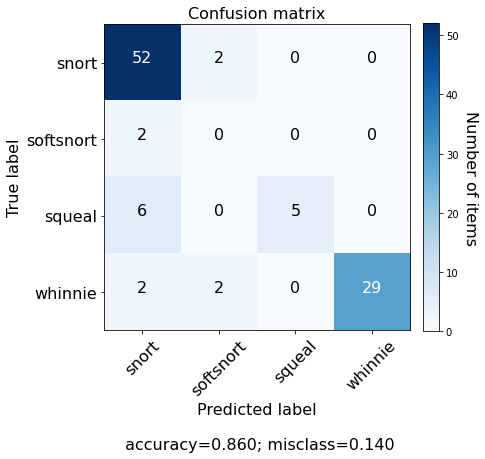

In [111]:
labels_list = np.unique(TEST_y)
onehot_y = TEST_CNN_y
truths = np.argmax(onehot_y, axis=1)
cm = confusion_matrix(truths, predictions, labels=range(num_classes))
plot_confusion_matrix(cm,labels_list,normalize=False,savefig = 'CM_CNN_OPT_INAUG_TEST')